In [25]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

from PIL import Image

In [26]:
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [27]:
batch_size = 16
data_dir = "/Users/anna-alexandradanchenko/local/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename


# for filename in os.listdir(data_dir):
#     img = Image.open(data_dir + "/" + filename)

In [28]:
# Converts images to floating-point tensors automatically

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="training",

    labels='inferred',
    label_mode="categorical",
        
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='bilinear',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="validation",

    labels='inferred',
    label_mode="categorical",
    
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='bilinear',
    shuffle=False
)


Found 710 files belonging to 7 classes.


Using 568 files for training.
Found 710 files belonging to 7 classes.
Using 142 files for validation.


In [29]:
class_names = df_train_.class_names
print(class_names)

['cubic', 'linear', 'negative_cubic', 'negative_linear', 'negative_quadratic', 'quadratic', 'square_root']


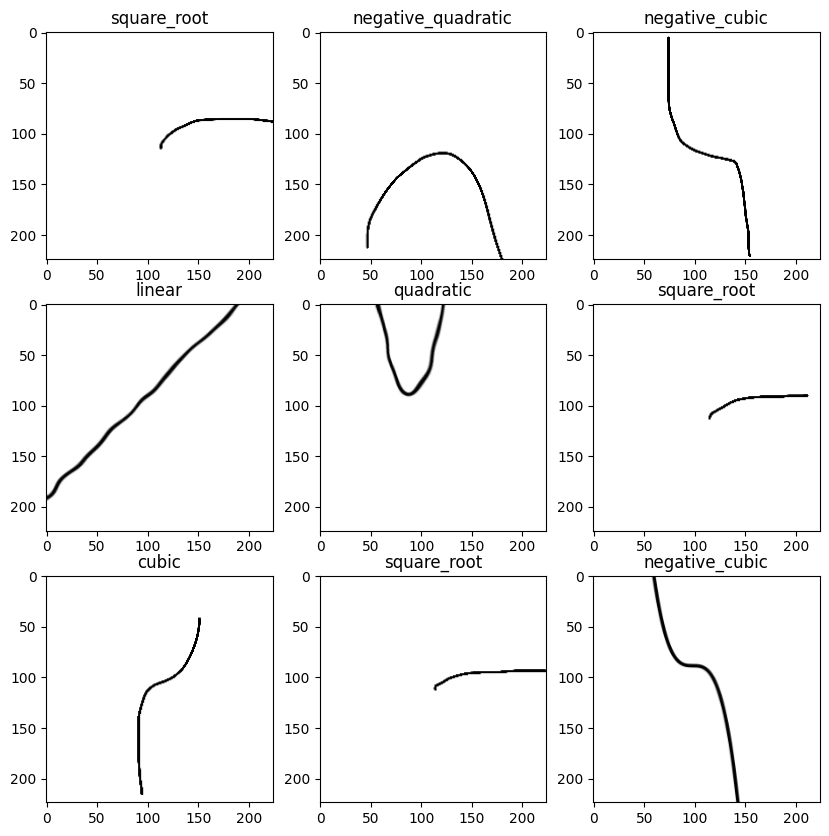

In [30]:
plt.figure(figsize=(10, 10))

for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy()) # Returns the indices of the maximum values.
    plt.title(class_names[label_index])



## Dataset Optimization

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = (
    df_train_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Model Definition

In [32]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2",
        trainable=False
        ),  
    layers.Flatten(), # Used to transition from convolutional layer to fully connected layer
    layers.Dense(256, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [33]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [34]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=8
    )

Epoch 1/8
36/36 [==============================] - 5s 87ms/step - loss: 0.6215 - accuracy: 0.7500 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 2/8
36/36 [==============================] - 2s 57ms/step - loss: 0.2239 - accuracy: 0.8944 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 3/8
36/36 [==============================] - 2s 57ms/step - loss: 0.1393 - accuracy: 0.9525 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 4/8
36/36 [==============================] - 2s 56ms/step - loss: 0.0951 - accuracy: 0.9754 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/8
36/36 [==============================] - 2s 56ms/step - loss: 0.0634 - accuracy: 0.9912 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/8
36/36 [==============================] - 2s 58ms/step - loss: 0.0382 - accuracy: 0.9965 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/8
36/36 [==============================] - 2s 56ms/step - loss: 0.0292 - accuracy: 0.9982 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 8/8
36/36 [===

<Axes: >

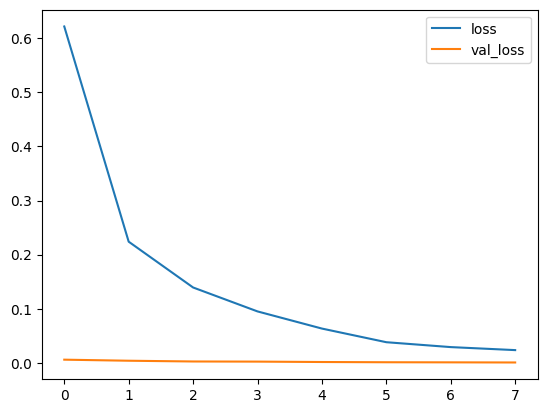

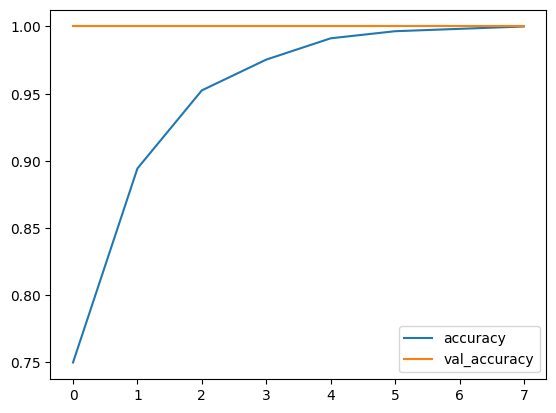

In [35]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

## Save the Model

In [36]:
model.save("model.keras")

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 1280)              410208    
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 739943 (2.82 MB)
Trainable params: 329735 (1.26 MB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


Test prediction of one image

In [38]:
model_loaded = load_model("model.keras", custom_objects={'KerasLayer':hub.KerasLayer})
img = Image.open("/Users/anna-alexandradanchenko/local/IdentMathFunc/Math-Functions-Identification/data/negative_linear/function_0.9_-1.5_9.0.png").resize((224, 224))
img = np.array(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
prediction = model_loaded.predict(img)
pred_class = np.argmax(prediction)
print(class_names[pred_class])

(1, 224, 224, 3)
1/1 [==============================] - 0s 260ms/step
negative_linear
